# Potential Amount of Streams Model

## Import Libraries and Load Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import random, os, boto3

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# import sagemaker
# from sagemaker import get_execution_role
# from sagemaker.amazon.amazon_estimator import get_image_uri
# from sagemaker.inputs import TrainingInput

# Set the style for seaborn plots
sns.set_style('whitegrid')

# This will not be used for now, it will be tested in the future for improvements

        # from sklearn.model_selection import train_test_split
        # from sklearn.preprocessing import StandardScaler, OneHotEncoder
        # from sklearn.compose import ColumnTransformer
        # from sklearn.pipeline import Pipeline
        # from sklearn.impute import SimpleImputer
        # from sklearn.linear_model import LinearRegression
        # from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        # from sklearn.ensemble import RandomForestRegressor
        # import tensorflow as tf
        # from tensorflow import keras
        # from tensorflow.keras.layers import Dense
        # from tensorflow.keras.optimizers import Adam

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
def splitData(data, train_ratio = 0.6, val_ratio = 0.2, test_ratio = 0.2):
    """
    Split the data into train, validation, and test sets.
    
    Args:
    - data: A list of data points.
    - train_ratio: Proportion of data to be used for training.
    - val_ratio: Proportion of data to be used for validation.
    - test_ratio: Proportion of data to be used for testing.
    
    Returns:
    - train_data: List of data points for training.
    - val_data: List of data points for validation.
    - test_data: List of data points for testing.
    """
    # Ensure ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1"
    
    # Shuffle the data
    shuffled_data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)
    
    # Split the data
    train_len = int(len(data) * train_ratio)
    val_len = int(len(data) * val_ratio)
    
    train_data = shuffled_data[:train_len]
    val_data = shuffled_data[train_len:train_len + val_len]
    test_data = shuffled_data[train_len + val_len:]
    
    return train_data, val_data, test_data


In [28]:
def collectSongDetails():
    """
    Interactively collects details about a song from the user and returns a DataFrame containing the provided details.

    The function prompts the user to provide the following song attributes:
    - Track name
    - Artist(s) name
    - Number of artists
    - Release date details: year, month, and day
    - Inclusion in Spotify playlists and charts
    - Inclusion in Apple Music playlists and charts
    - Number of playlist adds
    - Song's BPM (beats per minute)
    - Song's key (e.g., C, D, E, ...)
    - Song's mode (Major or Minor)
    - Various song characteristics as percentages (e.g., danceability, valence, energy, etc.)

    Returns:
    - song_data (pd.DataFrame): A DataFrame containing the collected details about the song, with each attribute as a column.

    Example:
    >>> song_data = collectSongDetails()
    >>> print(song_data)
         track_name artist(s)_name  artist_count ... speechiness_%
    0  Song Example       ArtistX             1 ...          0.5
    """
    
    track_name = input("Enter track name: ")
    artist_name = input("Enter artist(s) name: ")
    artist_count = int(input("Enter number of artists: "))
    released_year = int(input("Enter released year (e.g., 2023): "))
    released_month = int(input("Enter released month (1-12): "))
    released_day = int(input("Enter released day (1-31): "))
    
    in_spotify_playlists = int(input("Enter number of Spotify playlists song is in: "))
    in_spotify_charts = int(input("Enter 1 if the song is in Spotify charts, 0 otherwise: "))
    in_apple_playlists = int(input("Enter number of Apple Music playlists song is in: "))
    in_apple_charts = int(input("Enter 1 if the song is in Apple Music charts, 0 otherwise: "))
    
    playlist_adds = int(input("Enter number of playlist adds: "))
    bpm = int(input("Enter song's BPM (beats per minute): "))
    key = input("Enter song's key (e.g., C, D, E, ...): ")
    mode = input("Enter song's mode (Major or Minor): ")
    
    danceability = float(input("Enter song's danceability percentage (0-1): "))
    valence = float(input("Enter song's valence percentage (0-1): "))
    energy = float(input("Enter song's energy percentage (0-1): "))
    acousticness = float(input("Enter song's acousticness percentage (0-1): "))
    instrumentalness = float(input("Enter song's instrumentalness percentage (0-1): "))
    liveness = float(input("Enter song's liveness percentage (0-1): "))
    speechiness = float(input("Enter song's speechiness percentage (0-1): "))
    
    # Create a DataFrame with the collected data
    collected_data = {
        'track_name': [track_name],
        'artist(s)_name': [artist_name],
        'artist_count': [artist_count],
        'released_year': [released_year],
        'released_month': [released_month],
        'released_day': [released_day],
        'in_spotify_playlists': [in_spotify_playlists],
        'in_spotify_charts': [in_spotify_charts],
        'in_apple_playlists': [in_apple_playlists],
        'in_apple_charts': [in_apple_charts],
        'playlist_adds': [playlist_adds],
        'bpm': [bpm],
        'key': [key],
        'mode': [mode],
        'danceability_%': [danceability],
        'valence_%': [valence],
        'energy_%': [energy],
        'acousticness_%': [acousticness],
        'instrumentalness_%': [instrumentalness],
        'liveness_%': [liveness],
        'speechiness_%': [speechiness]
    }
    
    song_data = pd.DataFrame(collected_data)
    return song_data

In [5]:
# Load the dataset using the 'ISO-8859-1' encoding
role = get_execution_role()
bucket = 'streamspotential'
data_location = 's3://streamspotential/spotify-2023.csv'

spotify_data = pd.read_csv(data_location, encoding = 'ISO-8859-1')

# Display the first few rows of the dataset
spotify_data.head()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


## Check the Dataset Stats and Prepare it for Preprocessing

In [6]:
# Check for the missing values
missing_values = spotify_data.isnull().sum()

# Descriptive statistics
desc_stats = spotify_data.describe()

print('These are the number of missing values in each column:\n', missing_values)
print('These are the statistic values of each column:\n',desc_stats)

These are the number of missing values in each column:
 track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64
These are the statistic values of each column:
        artist_count  released_year  released_month  released_day  \
count    953.000000     953.000000      953.000000    953.000000   
mean       1.556139    2018.238195        6.033578     13.930745   
std        0.893044      11.116

In [7]:
# Check the datatype of the 'streams' column
streams_datatype = spotify_data['streams'].dtype

print('The data type of \'streams\' column is:', streams_datatype)

The data type of 'streams' column is: object


In [8]:
# Convert the 'streams' column to numeric type
spotify_data['streams'] =  pd.to_numeric(spotify_data['streams'], errors = 'coerce')

# Checking for any NaN values in the 'streams' column after conversion
nan_streams = spotify_data['streams'].isnull().sum()

print('There are', nan_streams, 'NaN data points in \'streams\' column')

There are 1 NaN data points in 'streams' column


In [9]:
# Extracting the row with the NaN value in the 'streams' column
nan_streams_row = spotify_data[spotify_data['streams'].isnull()]

nan_streams_row

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
574,Love Grows (Where My Rosemary Goes),Edison Lighthouse,1,1970,1,1,2877,0,NaN,16,...,110,A,Major,53,75,69,7,0,17,3


In [10]:
# Clear any duplicate rows in the dataset
spotify_data = spotify_data.drop_duplicates()

#  Clear any the rows that have a NaN value in the 'streams' column
spotify_data = spotify_data.dropna(subset = ['streams'])

# Checking the shape of the dataframe after dropping the row
data_shape = spotify_data.shape

print('This is the data shape after dropping the NaN:', data_shape)

This is the data shape after dropping the NaN: (952, 24)


In [11]:
# Correlation with 'streams' column after dropping the NaN row
corr_w_streams = spotify_data.corr()['streams'].sort_values(ascending = False)

print('These are the correlations of the columns in the table with \'stream\' column:\n', corr_w_streams)

These are the correlations of the columns in the table with 'stream' column:
 streams                 1.000000
in_spotify_playlists    0.789822
in_apple_playlists      0.772063
in_apple_charts         0.320234
in_spotify_charts       0.245821
in_deezer_charts        0.228598
released_day            0.010598
bpm                    -0.002438
acousticness_%         -0.004485
released_month         -0.024938
energy_%               -0.026051
valence_%              -0.040831
instrumentalness_%     -0.044902
liveness_%             -0.048337
danceability_%         -0.105457
speechiness_%          -0.112333
artist_count           -0.136463
released_year          -0.230803
Name: streams, dtype: float64


## Visualize the Dataset for Preprocessing

In [12]:
# Add a plot for the distribiution of 'streams'

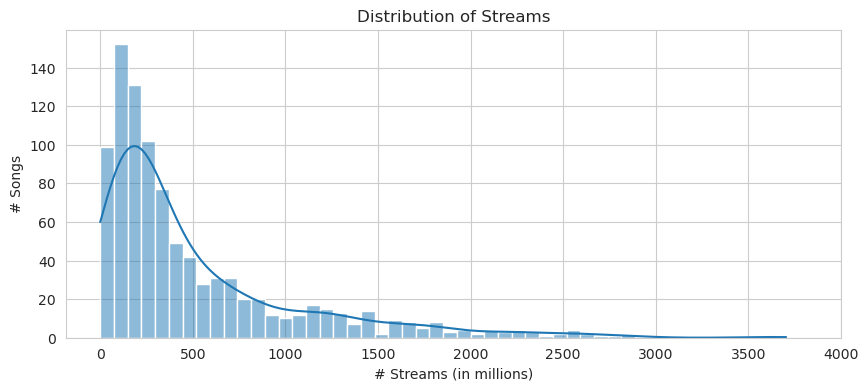

In [13]:
# Plot the distribution of the 'streams' variable
plt.figure(figsize = (10, 4))
sns.histplot(spotify_data['streams'], bins = 50, kde = True)
tick_loc = [0, 0.5e9, 1.0e9, 1.5e9, 2.0e9, 2.5e9, 3.0e9, 3.5e9, 4.0e9]
tick_label = ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000']
plt.xticks(tick_loc, tick_label)
plt.title('Distribution of Streams')
plt.xlabel('# Streams (in millions)')
plt.ylabel('# Songs')
plt.show()

In [14]:
# List of all the features
features_list = list(spotify_data.columns)

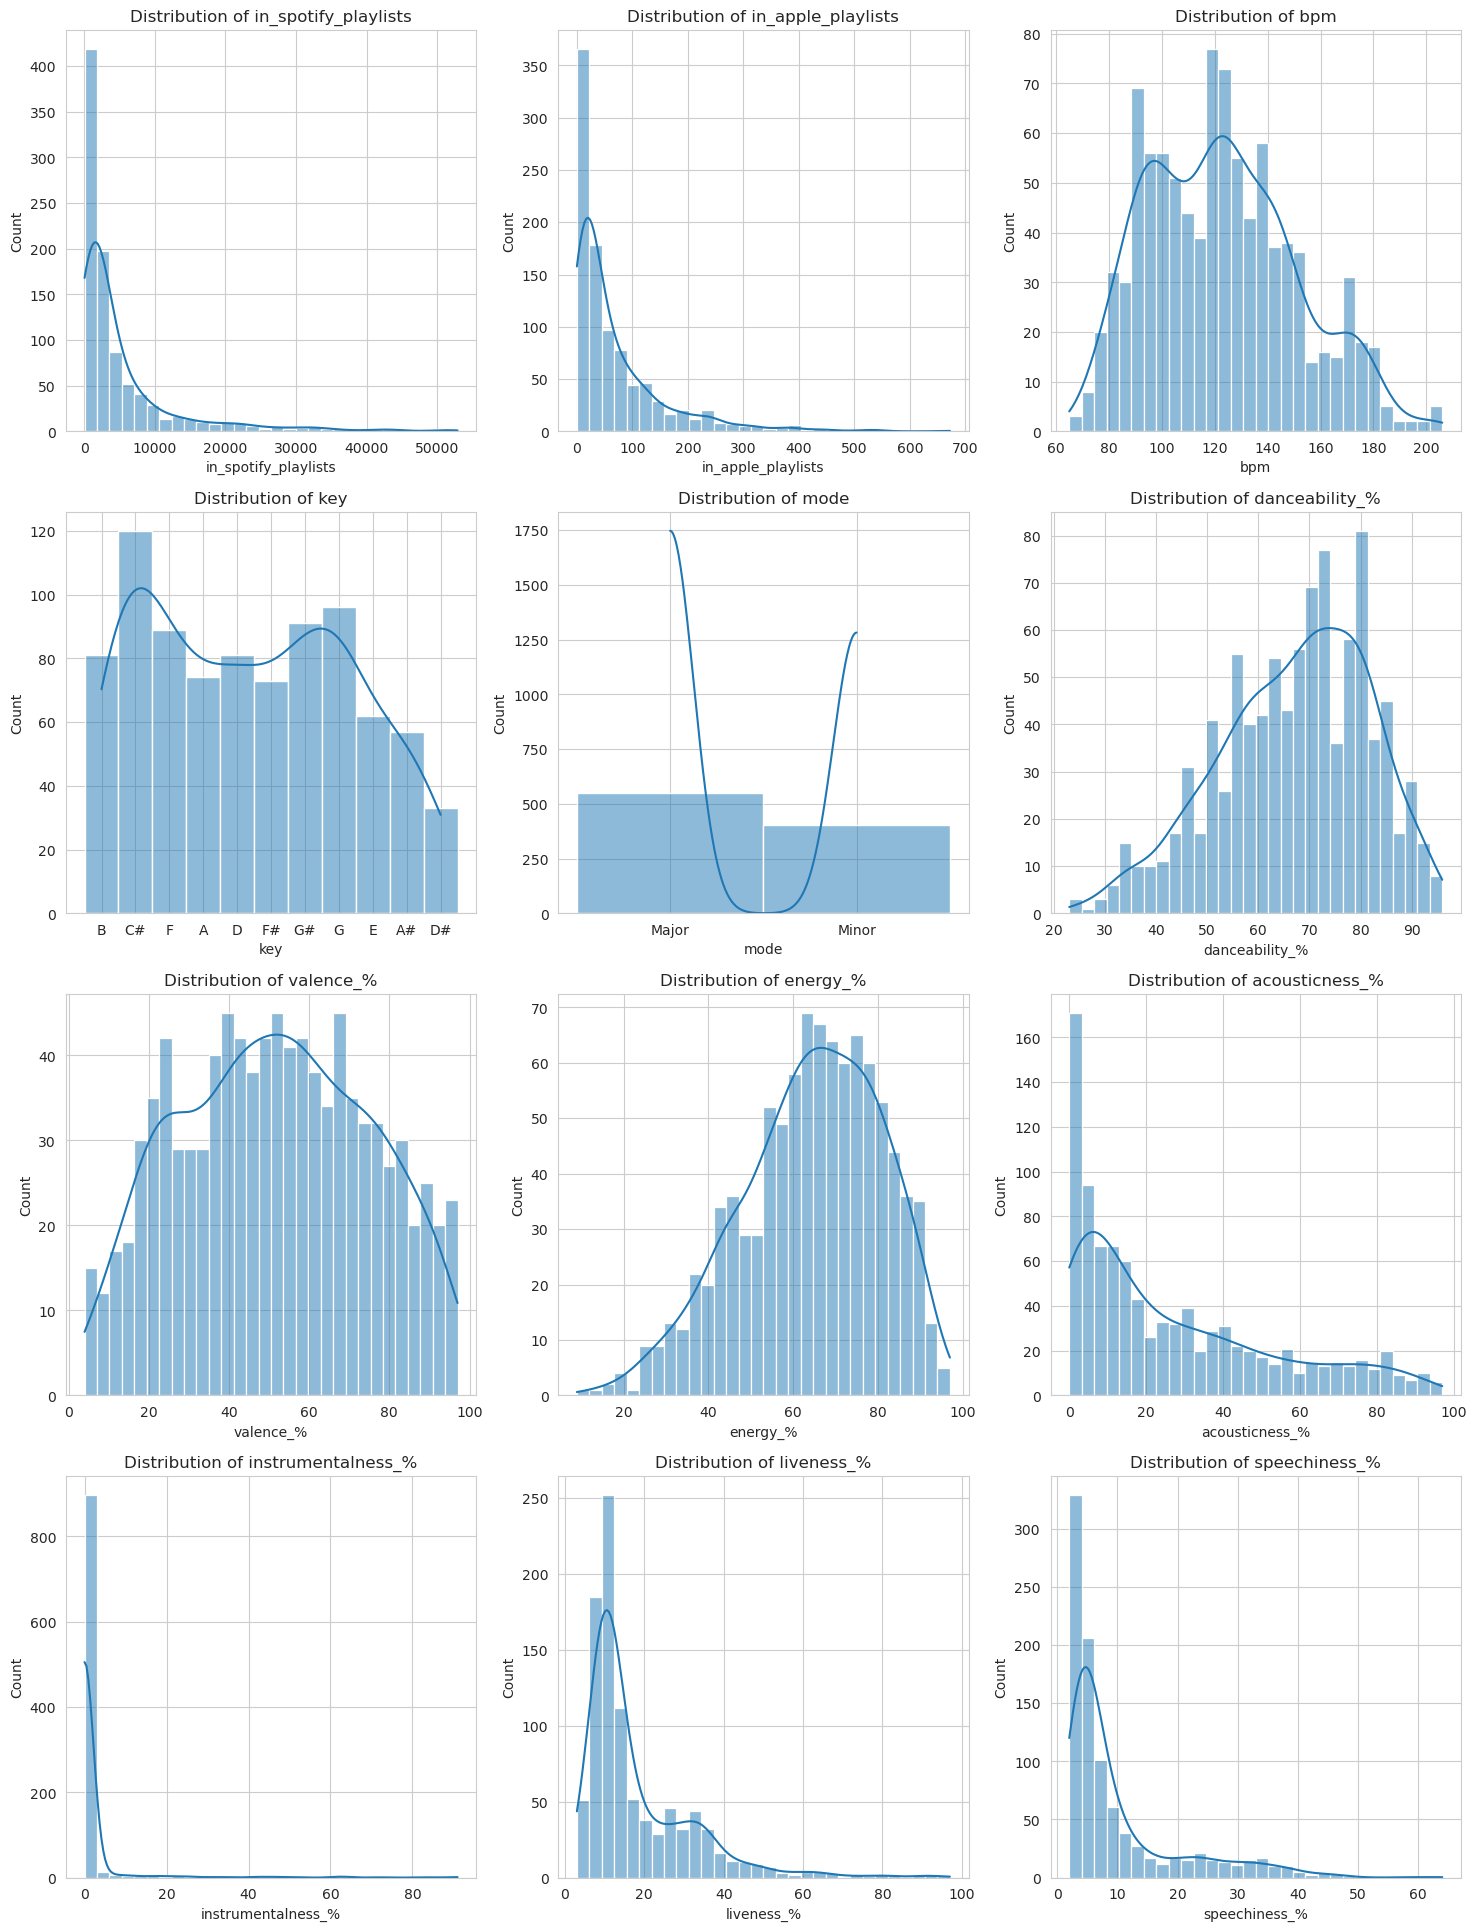

In [15]:
# List of key numeric features for Distribution analysis
exclude_non_num = [0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13]
key_list = [features_list[i] for i in range(len(features_list)) if i not in exclude_non_num]

# Plot the distribution of key numeric features
plt.figure(figsize = (18, 24))

for i, feature in enumerate(key_list, 1):
    plt.subplot(4, 3, i)
    sns.histplot(spotify_data[feature], bins = 30, kde = True)
    plt.title(f'Distribution of {feature}')
    plt.tight_layout

plt.show()

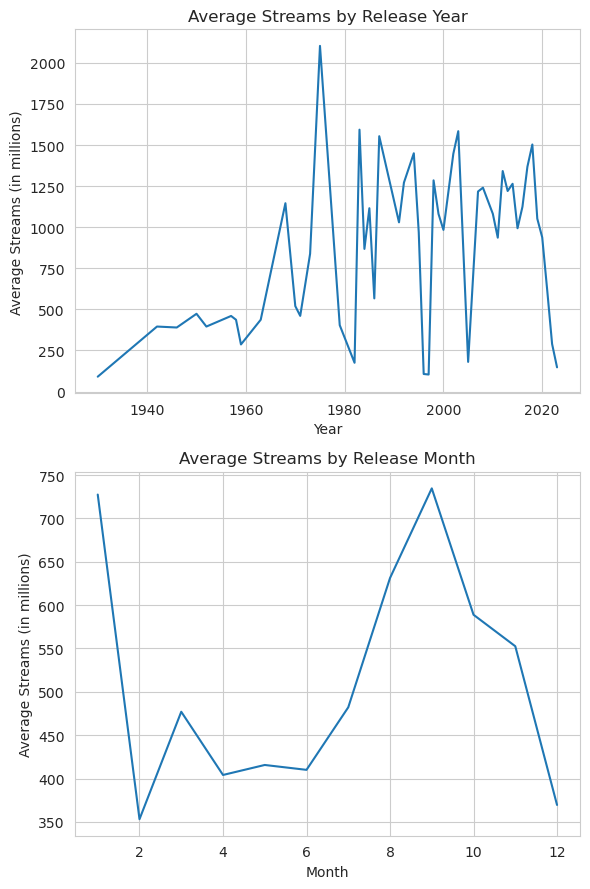

In [16]:
# Plot the distribution of key temporal features
plt.figure(figsize = (6, 9))

# Streams by release year
plt.subplot(2, 1, 1)
yearly_streams = spotify_data.groupby('released_year')['streams'].mean()
sns.lineplot(x = yearly_streams.index, y = yearly_streams.values)
tick_loc = [0, 0.25e9, 0.5e9, 0.75e9, 1.0e9, 1.25e9, 1.5e9, 1.75e9, 2.0e9]
tick_label = ['0', '250', '500', '750', '1000', '1250', '1500', '1750', '2000']
plt.yticks(tick_loc, tick_label)
plt.title('Average Streams by Release Year')
plt.xlabel('Year')
plt.ylabel('Average Streams (in millions)')

# Streams by release month
plt.subplot(2, 1, 2)
monthly_streams = spotify_data.groupby('released_month')['streams'].mean()
sns.lineplot(x = monthly_streams.index, y = monthly_streams.values)
tick_loc = [3.5e8, 4.0e8, 4.5e8, 5.0e8, 5.5e8, 6.0e8, 6.5e8, 7.0e8, 7.5e8]
tick_label = ['350', '400', '450', '500', '550', '600', '650', '700', '750']
plt.yticks(tick_loc, tick_label)
plt.title('Average Streams by Release Month')
plt.xlabel('Month')
plt.ylabel('Average Streams (in millions)')

plt.tight_layout()
plt.show()

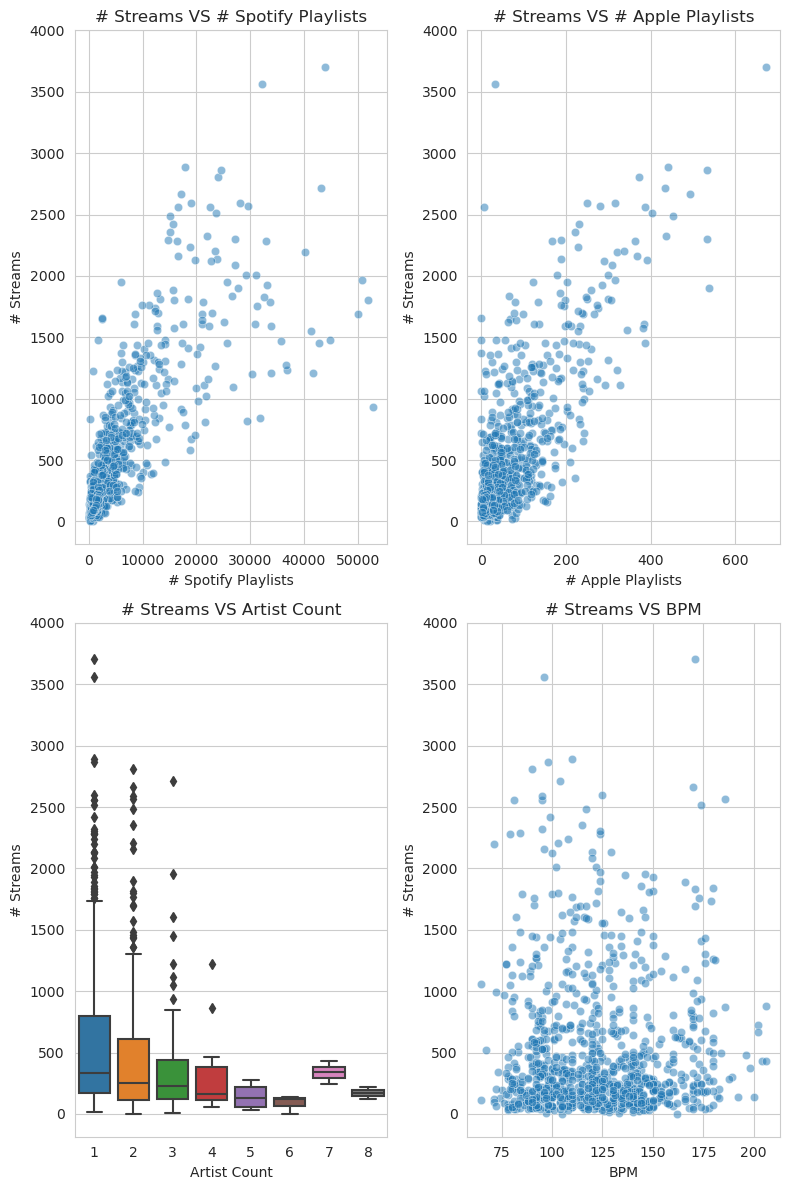

In [17]:
# Plot the feature relationship between number of streams and other key features
plt.figure(figsize = (8, 12))

# Streams VS Spotify Playlists
plt.subplot(2, 2, 1)
sns.scatterplot(x = spotify_data['in_spotify_playlists'], y = spotify_data['streams'], alpha = 0.5)
tick_loc = [0, 0.5e9, 1.0e9, 1.5e9, 2.0e9, 2.5e9, 3.0e9, 3.5e9, 4.0e9]
tick_label = ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000']
plt.yticks(tick_loc, tick_label)
plt.title('# Streams VS # Spotify Playlists')
plt.xlabel('# Spotify Playlists')
plt.ylabel('# Streams')

# Streams VS Apple Playlists
plt.subplot(2, 2, 2)
sns.scatterplot(x = spotify_data['in_apple_playlists'], y = spotify_data['streams'], alpha = 0.5)
tick_loc = [0, 0.5e9, 1.0e9, 1.5e9, 2.0e9, 2.5e9, 3.0e9, 3.5e9, 4.0e9]
tick_label = ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000']
plt.yticks(tick_loc, tick_label)
plt.title('# Streams VS # Apple Playlists')
plt.xlabel('# Apple Playlists')
plt.ylabel('# Streams')

# Streams VS Artist Count
plt.subplot(2, 2, 3)
sns.boxplot(x = spotify_data['artist_count'], y = spotify_data['streams'])
tick_loc = [0, 0.5e9, 1.0e9, 1.5e9, 2.0e9, 2.5e9, 3.0e9, 3.5e9, 4.0e9]
tick_label = ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000']
plt.yticks(tick_loc, tick_label)
plt.title('# Streams VS Artist Count')
plt.xlabel('Artist Count')
plt.ylabel('# Streams')

# Streams VS BMP
plt.subplot(2, 2, 4)
sns.scatterplot(x = spotify_data['bpm'], y = spotify_data['streams'], alpha = 0.5)
tick_loc = [0, 0.5e9, 1.0e9, 1.5e9, 2.0e9, 2.5e9, 3.0e9, 3.5e9, 4.0e9]
tick_label = ['0', '500', '1000', '1500', '2000', '2500', '3000', '3500', '4000']
plt.yticks(tick_loc, tick_label)
plt.title('# Streams VS BPM')
plt.xlabel('BPM')
plt.ylabel('# Streams')

plt.tight_layout()
plt.show()

## Machine Learning Models

### Deactivated Models

#### Preparing the dataset for train and test

In [18]:
# This will not be used for now, it will be tested in the future for improvements

# # Features and Target
# X = spotify_data.drop(columns = 'streams')
# y = spotify_data['streams']

# # Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# # Identify numeric and categorical columns
# numeric_features = X.select_dtypes(include = ['int64', 'float64']).columns.tolist()
# categorical_features = X.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()

# # Create transformers for numeric and categorical columns
# numeric_transformer = Pipeline(steps = [
#     ('imputer', SimpleImputer(strategy = 'mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps = [
#     ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')),
#     ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
# ])

# # Combine the transformers using ColumnTransformer
# preprocessor = ColumnTransformer(
#     transformers = [
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

#### Linear Regression Model

In [19]:
# This will not be used for now, it will be tested in the future for improvements

# # Create and evaluating the regression model
# model = Pipeline(steps = [('preprocessor', preprocessor),
#                         ('regressor', LinearRegression())])

# # Train the model
# model.fit(X_train, y_train)

# # Predictions
# y_pred = model.predict(X_test)

# # Evaluation metrics
# lr_mae = mean_absolute_error(y_test, y_pred)
# lr_mse = mean_squared_error(y_test, y_pred)
# lr_r2 = r2_score(y_test, y_pred)

# print('The Mean Absolute Error is: ', lr_mae)
# print('The Mean Squared Error is: ', lr_mse)
# print('The R-squared is: ', lr_r2)

#### Random Forest Model

In [20]:
# This will not be used for now, it will be tested in the future for improvements

# # Create and evaluate the Random Forest model
# rf_model = Pipeline(steps = [('preprocessor', preprocessor),
#                            ('regressor', RandomForestRegressor(n_estimators = 100, random_state = 1))])

# # Train the model
# rf_model.fit(X_train, y_train)

# # Predictions
# y_rf_pred = rf_model.predict(X_test)

# # Evaluation metrics
# rf_mae = mean_absolute_error(y_test, y_rf_pred)
# rf_mse = mean_squared_error(y_test, y_rf_pred)
# rf_r2 = r2_score(y_test, y_rf_pred)

# print('The Mean Absolute Error is: ', rf_mae)
# print('The Mean Squared Error is: ', rf_mse)
# print('The R-squared is: ', rf_r2)

In [21]:
# This will not be used for now, it will be tested in the future for improvements

# # Extract feature importances from the Random Forest model
# feature_importances = rf_model.named_steps['regressor'].feature_importances_

# # Get feature names after one-hot encoding
# ohe_feature_names = (rf_model.named_steps['preprocessor']
#                      .named_transformers_['cat']
#                      .named_steps['onehot']
#                      .get_feature_names_out(input_features = categorical_features))

# all_feature_names = numeric_features + list(ohe_feature_names)

# # Create a DataFrame for feature importances
# feature_importance_df = pd.DataFrame({
#     'Feature': all_feature_names,
#     'Importance': feature_importances
# }).sort_values(by = 'Importance', ascending = False)

# # Display top 10 features based on importance
# top_features = feature_importance_df.head(10)

# top_features

#### Neural Network Model

In [22]:
# This will not be used for now, it will be tested in the future for improvements

# # Preprocessing
# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

# # Convert preprocessed data to dense arrays
# X_train_dense = X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed
# X_test_dense = X_test_processed.toarray() if hasattr(X_test_processed, 'toarray') else X_test_processed

# # Neural Network architecture
# input_dim = X_train_processed.shape[1]  # Number of features

# model = keras.Sequential([
#     Dense(128, activation='relu', input_dim=input_dim),
#     Dense(64, activation='relu'),
#     Dense(1)  # Single output neuron for regression
# ])

# # Compile the model
# model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# # Train the model
# history = model.fit(X_train_dense, y_train, epochs = 100, batch_size = 32, validation_data = (X_test_dense, y_test))

# # Predictions
# y_nn_pred = model.predict(X_test_processed)

# # Evaluation metrics
# nn_mae = mean_absolute_error(y_test, y_nn_pred)
# nn_mse = mean_squared_error(y_test, y_nn_pred)
# nn_r2 = r2_score(y_test, y_nn_pred)

# print('The Mean Absolute Error is: ', nn_mae)
# print('The Mean Squared Error is: ', nn_mse)
# print('The R-squared is: ', nn_r2)


### XGBoost Model

In [23]:
# Split the dataset to train (60%), cross-validation (20%) and test (20%)
train_data, val_data, test_data = splitData(spotify_data)

# Move 'streams' column to be the first column in each set
rearranged_train_data = train_data[['streams'] + [col for col in train_data.columns if col != 'streams']]
rearranged_val_data = val_data[['streams'] + [col for col in val_data.columns if col != 'streams']]
rearranged_test_data = test_data[['streams'] + [col for col in test_data.columns if col != 'streams']]

# Select only numeric columns
numeric_train_data = rearranged_train_data.select_dtypes(include = [np.number])
numeric_val_data = rearranged_val_data.select_dtypes(include = [np.number])
numeric_test_data = rearranged_test_data.select_dtypes(include = [np.number])

# Save the numeric data without headers
numeric_train_data.to_csv('numeric_train_data.csv', index = False, header = False)
numeric_val_data.to_csv('numeric_val_data.csv', index = False, header = False)
numeric_test_data.to_csv('numeric_test_data.csv', index = False, header = False)

# Upload rearranged data to S3
s3 = boto3.client('s3')
bucket_name = 'streamspotential'

s3.upload_file('numeric_train_data.csv', bucket_name, 'train/numeric_train_data.csv')
s3.upload_file('numeric_val_data.csv', bucket_name, 'validation/numeric_val_data.csv')
s3.upload_file('numeric_test_data.csv', bucket_name, 'test/numeric_test_data.csv')

train_s3_uri, val_s3_uri = f's3://{bucket_name}/train/numeric_train_data.csv', f's3://{bucket_name}/validation/numeric_val_data.csv'

In [24]:
# Train the model
container = get_image_uri(sagemaker.Session().boto_region_name, 'xgboost', repo_version = 'latest')
role = get_execution_role()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count = 1,
                                    instance_type = "ml.m4.xlarge",
                                    output_path = "s3://streamspotential/output",
                                    sagemaker_session = sagemaker.Session())

# Use the S3 URI for training and validation data
train_data_channel = TrainingInput(train_s3_uri, content_type = 'text/csv')
val_data_channel = TrainingInput(val_s3_uri, content_type = 'text/csv')

# Update the hyperparameters
xgb.set_hyperparameters(objective = "reg:linear",
                        eval_metric = "rmse",
                        num_round = 100)

# Train the model using both training and validation data
xgb.fit({'train': train_data_channel, 'validation': val_data_channel})

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: xgboost-2023-10-24-19-51-29-457


2023-10-24 19:51:29 Starting - Starting the training job...
2023-10-24 19:51:57 Starting - Preparing the instances for training......
2023-10-24 19:52:58 Downloading - Downloading input data......
2023-10-24 19:53:40 Training - Downloading the training image...
2023-10-24 19:54:21 Uploading - Uploading generated training modelArguments: train
[2023-10-24:19:54:17:INFO] Running standalone xgboost training.
[2023-10-24:19:54:17:INFO] File size need to be processed in the node: 0.04mb. Available memory size in the node: 8551.55mb
[2023-10-24:19:54:17:INFO] Determined delimiter of CSV input is ','
[19:54:17] S3DistributionType set as FullyReplicated
[19:54:17] 571x17 matrix with 9707 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-10-24:19:54:17:INFO] Determined delimiter of CSV input is ','
[19:54:17] S3DistributionType set as FullyReplicated
[19:54:17] 190x17 matrix with 3230 entries loaded from /opt/ml/input/data/validation?format=csv&label_colum

## Model Deployment

In [27]:
# Deploy the trained model
predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

# Set the content type of the input data
predictor.serializer = sagemaker.serializers.CSVSerializer()

# Get predictions on test data
numeric_test_data_only = numeric_test_data.drop(columns = ["streams"])
test_predictions = predictor.predict(numeric_test_data_only.values).decode('utf-8').split(',')

# Convert predictions to float
test_predictions = [float(value) for value in test_predictions]

# Calculate metrics
y_true = numeric_test_data["streams"].values
y_pred = test_predictions

xgb_mae = mean_absolute_error(y_true, y_pred)
xgb_mse = mean_squared_error(y_true, y_pred)
xgb_r2 = r2_score(y_true, y_pred)

print('The Mean Absolute Error is: ', xgb_mae)
print('The Mean Squared Error is: ', xgb_mse)
print('The R-squared is: ', xgb_r2)

INFO:sagemaker:Creating model with name: xgboost-2023-10-24-20-00-48-433
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-10-24-20-00-48-433
INFO:sagemaker:Creating endpoint with name xgboost-2023-10-24-20-00-48-433


-----!The Mean Absolute Error is:  146465088.33507854
The Mean Squared Error is:  5.406344508875653e+16
The R-squared is:  0.8254574797559487


## Model Prediction

In [ ]:
# Collect details
song_data = collectSongDetails()

In [ ]:
# Select only numeric columns
numeric_song_data = song_data.select_dtypes(include = [np.number])

# Save the numeric data without headers
numeric_song_data.to_csv('numeric_song_data.csv', index = False, header = False)

# Set the content type to CSV
predictor.content_type = 'text/csv'

# Predict using the deployed model
predicted_streams = predictor.predict(numeric_song_data)


print('The predicted amount of streams for the song "{}" by "{}" might be: {}'.format(
    song_data['track_name'].iloc[0], 
    song_data['artist(s)_name'].iloc[0], 
    np.fromstring(predicted_streams, sep = ',')[0]))

In [ ]:
print(type(predicted_streams))